# GARCH for PCA

In [91]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
import sklearn
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from sklearn.preprocessing import StandardScaler
from arch import arch_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error


# Load data
df = pd.read_excel('data/PCA Mastersheet.xlsx')
print(df.head())
print(df.columns.tolist())

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

       Month    PC1_macro     PC2_macro   Tether  USD Coin  PC1_crypto  \
0 2017-09-01  6067.698298 -18663.045363 -3.82830       NaN         NaN   
1 2017-10-01  6152.013916 -18689.272033 -3.73861       NaN         NaN   
2 2017-11-01  6143.421303 -18828.738277 -4.01951       NaN         NaN   
3 2017-12-01  6193.529376 -18878.593243 -2.55687       NaN         NaN   
4 2018-01-01  6243.197778 -18931.069455 -2.75193       NaN         NaN   

   PC2_crypto  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
['Month', 'PC1_macro', 'PC2_macro', 'Tether', 'USD Coin', 'PC1_crypto', 'PC2_crypto']


In [92]:
## Testing all combinations

macro_list = ['PC1_macro', 'PC2_macro']
asset_list= ['Tether', 'USD Coin','PC1_crypto','PC2_crypto']

In [93]:
from arch import arch_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd

def rolling_forecast_ar(y_train_scaled, y_test_scaled, p, q, l):
    history = list(y_train_scaled)
    preds = []

    for t in range(len(y_test_scaled)):
        model = arch_model(history, mean='AR', lags=l, vol='GARCH', p=p, q=q, dist='normal', rescale=False)
        res = model.fit(disp='off')
        forecast = res.forecast(horizon=1, method='analytic')
        pred = forecast.mean.values[-1, 0]
        preds.append(pred)
        history.append(y_test_scaled[t])

    return np.array(preds)

def rolling_forecast_arx(y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, p, q, l):
    history_y = list(y_train_scaled)
    history_x = list(x_train_scaled)
    preds = []

    for t in range(len(y_test_scaled)):
        x_arr = np.array(history_x)
        model = arch_model(history_y, mean='ARX', lags=l, vol='GARCH', p=p, q=q, x=x_arr, dist='normal', rescale=False)
        res = model.fit(disp='off')

        const = res.params.get('Const', 0)
        phi = res.params.get('y[1]', 0)
        beta = res.params.get('x0', 0)

        y_t = history_y[-1]
        x_t1 = x_test_scaled[t]

        pred = const + phi * y_t + beta * x_t1
        preds.append(pred)

        history_y.append(y_test_scaled[t])
        history_x.append(x_test_scaled[t])

    return np.array(preds)

results = []

for macro in macro_list:
    if f'{macro}_diff_diff' in df.columns:
        y_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in df.columns:
        y_col = f'{macro}_diff'
    else:
        y_col = macro

    for asset in asset_list:
        df_temp = df[[y_col, asset]].dropna().copy()
        if len(df_temp) < 30:
            print(f"Skipping {macro}-{asset}: insufficient data ({len(df_temp)})")
            continue

        y_var = df_temp[y_col].var()
        x_var = df_temp[asset].var()
        if y_var == 0 or x_var == 0:
            print(f"Skipping {macro}-{asset}: zero variance in y or x")
            continue

        scaler_y = StandardScaler()
        scaler_x = StandardScaler()
        y_scaled = scaler_y.fit_transform(df_temp[[y_col]]).flatten()
        x_scaled = scaler_x.fit_transform(df_temp[[asset]]).flatten()

        best_aic = np.inf
        best_res = None
        best_pq = (1, 1)

        for p in range(1, 6):
            for q in range(1, 6):
                try:
                    model = arch_model(
                        y_scaled, mean='ARX', lags=1, vol='GARCH',
                        p=p, q=q, x=x_scaled, dist='normal', rescale=False
                    )
                    res = model.fit(disp='off')
                    if res.aic < best_aic:
                        best_aic = res.aic
                        best_res = res
                        best_pq = (p, q)
                except:
                    continue

        if best_res is not None:
            train_size = int(len(df_temp) * 0.85)
            df_train = df_temp.iloc[:train_size]
            df_test = df_temp.iloc[train_size:]

            scaler_y = StandardScaler()
            scaler_x = StandardScaler()
            y_train_scaled = scaler_y.fit_transform(df_train[[y_col]]).flatten()
            x_train_scaled = scaler_x.fit_transform(df_train[[asset]]).flatten()
            y_test_scaled = scaler_y.transform(df_test[[y_col]]).flatten()
            x_test_scaled = scaler_x.transform(df_test[[asset]]).flatten()

            try:
                pred_ar_scaled = rolling_forecast_ar(y_train_scaled, y_test_scaled, best_pq[0], best_pq[1], 1)
                pred_arx_scaled = rolling_forecast_arx(y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, best_pq[0], best_pq[1], 1)

                pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()
                pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()
                y_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

                mse_ar = mean_squared_error(y_actual, pred_ar)
                mse_arx = mean_squared_error(y_actual, pred_arx)
                rmse_ar = np.sqrt(mse_ar)
                rmse_arx = np.sqrt(mse_arx)
                r2_ar = r2_score(y_actual, pred_ar)
                r2_arx = r2_score(y_actual, pred_arx)

                def safe_mape(actual, predicted):
                    actual, predicted = np.array(actual), np.array(predicted)
                    mask = actual != 0
                    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) if np.any(mask) else np.nan

                mape_ar = safe_mape(y_actual, pred_ar)
                mape_arx = safe_mape(y_actual, pred_arx)

                exog_params = [p for p in best_res.params.index if p.startswith('x')]
                coef = best_res.params[exog_params[0]] if exog_params else np.nan
                pval = best_res.pvalues[exog_params[0]] if exog_params else np.nan

                results.append({
                    'Macro': macro,
                    'Macro_col': y_col,
                    'Crypto': asset,
                    'Param': exog_params[0] if exog_params else None,
                    'Coef': coef,
                    'P-value': pval,
                    'AIC': best_res.aic,
                    'BIC': best_res.bic,
                    'p': best_pq[0],
                    'q': best_pq[1],
                    'MSE_AR': mse_ar,
                    'MSE_ARX': mse_arx,
                    'RMSE_AR': rmse_ar,
                    'RMSE_ARX': rmse_arx,
                    'R2_AR': r2_ar,
                    'R2_ARX': r2_arx,
                    'MAPE_AR': mape_ar,
                    'MAPE_ARX': mape_arx,
                    'MAPE_Improvement(%)': ((mape_arx - mape_ar) / mape_ar) * 100 if mape_ar != 0 else np.nan,
                    'Model_Success': True
                })
            except Exception as e:
                print(f"Rolling forecast failed for {macro}-{asset}: {e}")
        else:
            print(f"Error fitting model for {macro}-{asset}: No valid model found")
            results.append({
                'Macro': macro,
                'Macro_col': y_col,
                'Crypto': asset,
                'Param': None,
                'Coef': np.nan,
                'P-value': np.nan,
                'AIC': np.nan,
                'BIC': np.nan,
                'p': np.nan,
                'q': np.nan,
                'MSE_AR': np.nan,
                'MSE_ARX': np.nan,
                'RMSE_AR': np.nan,
                'RMSE_ARX': np.nan,
                'R2_AR': np.nan,
                'R2_ARX': np.nan,
                'MAPE_AR': np.nan,
                'MAPE_ARX': np.nan,
                'MAPE_Improvement(%)': np.nan,
                'Model_Success': False
            })

# Show results
results_df = pd.DataFrame(results)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

display(results_df.sort_values(by='MAPE_Improvement(%)', ascending=True, na_position='last'))

,Macro,Macro_col,Crypto,Param,Coef,P-value,AIC,BIC,p,q,MSE_AR,MSE_ARX,RMSE_AR,RMSE_ARX,R2_AR,R2_ARX,MAPE_AR,MAPE_ARX,MAPE_Improvement(%),Model_Success
7,PC2_macro,PC2_macro,PC2_crypto,x0,-0.046104,0.000170,-79.645609,-65.132566,1,1,13066.629754,9639.058636,114.309360,98.178708,0.689737,0.771123,0.004523,0.004116,-9.008191,True
5,PC2_macro,PC2_macro,USD Coin,x0,0.022229,0.197191,-28.222265,-14.562268,1,1,10899.990668,9962.134059,104.403020,99.810491,0.616500,0.649497,0.003911,0.003730,-4.633048,True
2,PC1_macro,PC1_macro,PC1_crypto,x0,-0.000089,0.988107,-44.284282,-29.771238,1,1,12665.229505,12555.748073,112.539902,112.052434,0.719377,0.721803,0.004074,0.004182,2.632427,True
4,PC2_macro,PC2_macro,Tether,x0,-0.000524,0.959780,-56.043341,-38.701983,2,1,11318.292588,10824.852823,106.387464,104.042553,0.737592,0.749032,0.004367,0.004485,2.694306,True
6,PC2_macro,PC2_macro,PC1_crypto,x0,-0.033875,0.106777,-54.702075,-37.770191,2,1,14767.275795,17886.018786,121.520681,133.738621,0.649355,0.575302,0.005128,0.005445,6.190591,True
3,PC1_macro,PC1_macro,PC2_crypto,x0,-0.017736,0.169532,-45.124432,-30.611388,1,1,12665.229505,19347.868384,112.539902,139.096615,0.719377,0.571311,0.004074,0.005766,41.523941,True
1,PC1_macro,PC1_macro,USD Coin,x0,0.005690,0.855668,-179.598774,-165.938777,1,1,11600.728606,20003.144168,107.706679,141.432472,0.723339,0.522954,0.003724,0.005442,46.102576,True
0,PC1_macro,PC1_macro,Tether,x0,-0.037600,0.322526,-60.414402,-45.550381,1,1,11904.723174,24463.679450,109.108768,156.408694,0.718766,0.422077,0.004002,0.006235,55.805051,True


In [94]:
def rolling_forecast_ar(y_train_scaled, y_test_scaled, p, q,l):
    history = list(y_train_scaled)
    preds = []

    for t in range(len(y_test_scaled)):
        model = arch_model(history, mean='AR', lags=l, vol='GARCH', p=p, q=q, dist='normal')
        res = model.fit(disp='off')
        forecast = res.forecast(horizon=1, method='analytic')
        pred = forecast.mean.values[-1, 0]
        preds.append(pred)
        history.append(y_test_scaled[t])  # Add actual value for next iteration

    return np.array(preds)

In [95]:
def plot_garch_mean_predictions_rolling(df, macro, asset, y_col, p, q,l,title_suffix=""):
    df_temp = df[[y_col, asset]].dropna().copy()
    if len(df_temp) < 30:
        print(f"Skipping {macro}-{asset}: insufficient data ({len(df_temp)})")
        return

    train_size = int(len(df_temp) * 0.85)
    df_train = df_temp.iloc[:train_size]
    df_test = df_temp.iloc[train_size:]

    # Scale separately to avoid leakage
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(df_train[[y_col]]).flatten()
    x_train_scaled = scaler_x.fit_transform(df_train[[asset]]).flatten()
    y_test_scaled = scaler_y.transform(df_test[[y_col]]).flatten()
    x_test_scaled = scaler_x.transform(df_test[[asset]]).flatten()

    try:
        # Rolling forecasts
        pred_ar_scaled = rolling_forecast_ar(y_train_scaled, y_test_scaled, int(p), int(q),int(l))
        pred_arx_scaled = rolling_forecast_arx(
            y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, int(p), int(q),int(l)
        )

        # Inverse scale
        pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()
        pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()
        y_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
        index_test = df_test.index

        # ✅ Compute MAPE values
        def safe_mape(actual, predicted):
            actual, predicted = np.array(actual), np.array(predicted)
            mask = actual != 0
            return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100 if np.any(mask) else np.nan

        mape_ar = safe_mape(y_actual, pred_ar)
        mape_arx = safe_mape(y_actual, pred_arx)
        mape_change = ((mape_arx - mape_ar) / mape_ar) * 100 if mape_ar != 0 else np.nan

        print(f"MAPE AR: {mape_ar:.2f}%, ARX: {mape_arx:.2f}%, ARX improvement: {mape_change:.2f}%")

        # Plot results
        plt.figure(figsize=(10, 5))
        plt.plot(index_test, y_actual, label='Actual (Test)', color='black', marker='o')
        plt.plot(index_test, pred_ar, label='AR Forecast (Rolling)', linestyle='--', marker='x')
        plt.plot(index_test, pred_arx, label='ARX Forecast (Rolling)', linestyle='--', marker='s')
        plt.title(f'{macro}-{asset} GARCH Mean Rolling Forecasts {title_suffix}')
        plt.xlabel('Time')
        plt.ylabel(y_col)
        plt.fill_between(index_test, y_actual * 0.95, y_actual * 1.05, color='gray', alpha=0.2, label='±5% Bandwidth')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Plotting failed for {macro}-{asset}: {e}")

MAPE AR: 0.45%, ARX: 0.41%, ARX improvement: -9.01%


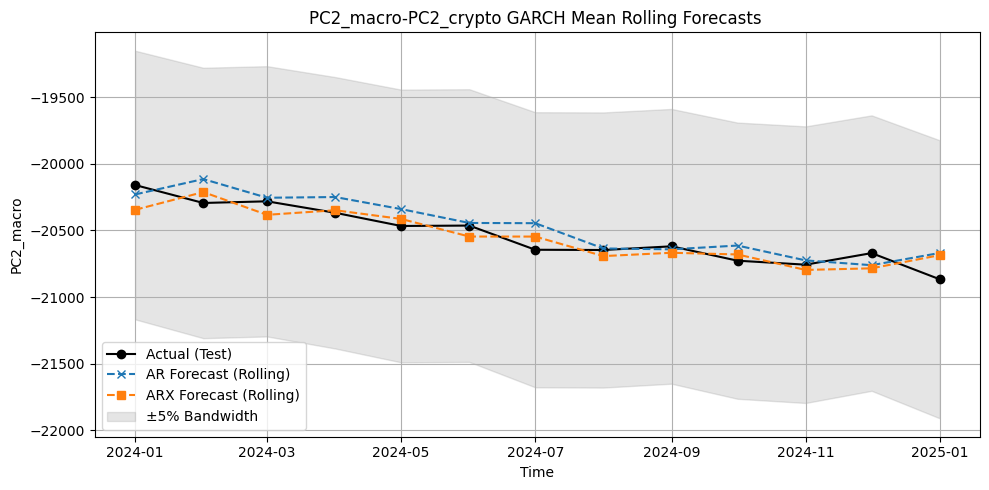

In [96]:
plot_garch_mean_predictions_rolling(df, 'PC2_macro', 'PC2_crypto', 'PC2_macro', 1, 1,1)

MAPE AR: 0.39%, ARX: 0.37%, ARX improvement: -4.63%


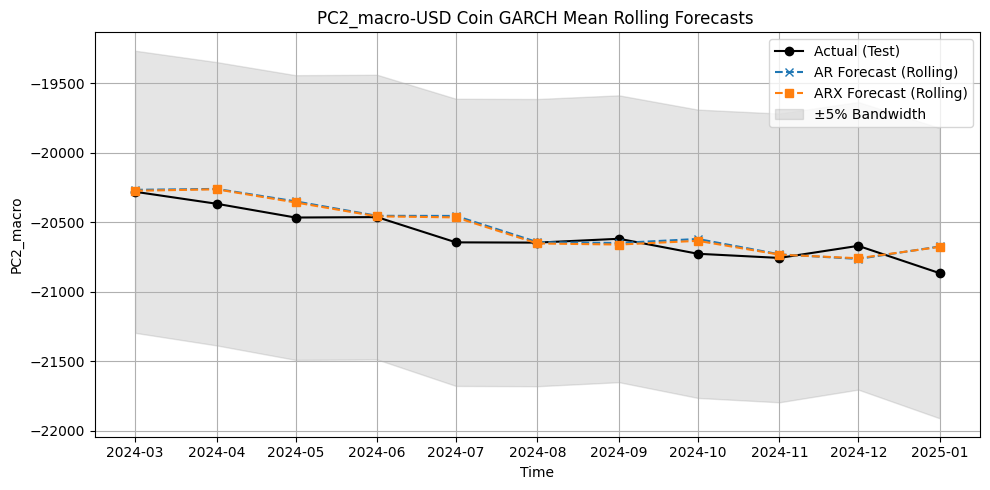

In [97]:
plot_garch_mean_predictions_rolling(df, 'PC2_macro', 'USD Coin','PC2_macro', 1, 1, 1)


In [98]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def plot_garch_with_train_test(df, macro, asset, y_col, p, q, l, title_suffix=""):
    # Drop NaNs to keep consistent
    df_temp = df[[y_col, asset]].dropna().copy()
    if len(df_temp) < 30:
        print(f"Skipping {macro}-{asset}: insufficient data ({len(df_temp)})")
        return
    train_size = int(len(df_temp) * 0.85)
    df_train = df_temp.iloc[:train_size]
    df_test = df_temp.iloc[train_size:]
    # Scale separately to avoid leakage
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(df_train[[y_col]]).flatten()
    x_train_scaled = scaler_x.fit_transform(df_train[[asset]]).flatten()
    y_test_scaled = scaler_y.transform(df_test[[y_col]]).flatten()
    x_test_scaled = scaler_x.transform(df_test[[asset]]).flatten()

    # Rolling forecasts on test set
    pred_ar_scaled = rolling_forecast_ar(y_train_scaled, y_test_scaled, p, q, l)
    pred_arx_scaled = rolling_forecast_arx(y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, p, q, l)

    # Inverse transform all
    y_train_inv = scaler_y.inverse_transform(y_train_scaled.reshape(-1, 1)).flatten()
    y_test_inv = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
    pred_ar_inv = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()
    pred_arx_inv = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()

    # Prepare x-axis index for train + test
    index_train = df_train.index
    index_test = df_test.index

    plt.figure(figsize=(12, 6))

    # Plot training actuals
    plt.plot(index_train, y_train_inv, label='Actual (Train)', color='blue')

    # Plot test actuals
    plt.plot(index_test, y_test_inv, label='Actual (Test)', color='black', linewidth=2)

    # Plot AR forecasts on test set
    plt.plot(index_test, pred_ar_inv, label='AR Forecast (Rolling)', linestyle='--', color='orange')

    # Plot ARX forecasts on test set
    plt.plot(index_test, pred_arx_inv, label='ARX Forecast (Rolling)', linestyle='--', color='green')

    # Add ±5% band around ARX forecast
    band_upper = pred_arx_inv * 1.05
    band_lower = pred_arx_inv * 0.95
    plt.fill_between(index_test, band_lower, band_upper, color='gray', alpha=0.3, label='±5% Bandwidth')

    plt.title(f'{macro}-{asset} GARCH Mean Rolling Forecasts with Train and Test {title_suffix}')
    plt.xlabel('Time')
    plt.ylabel(y_col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


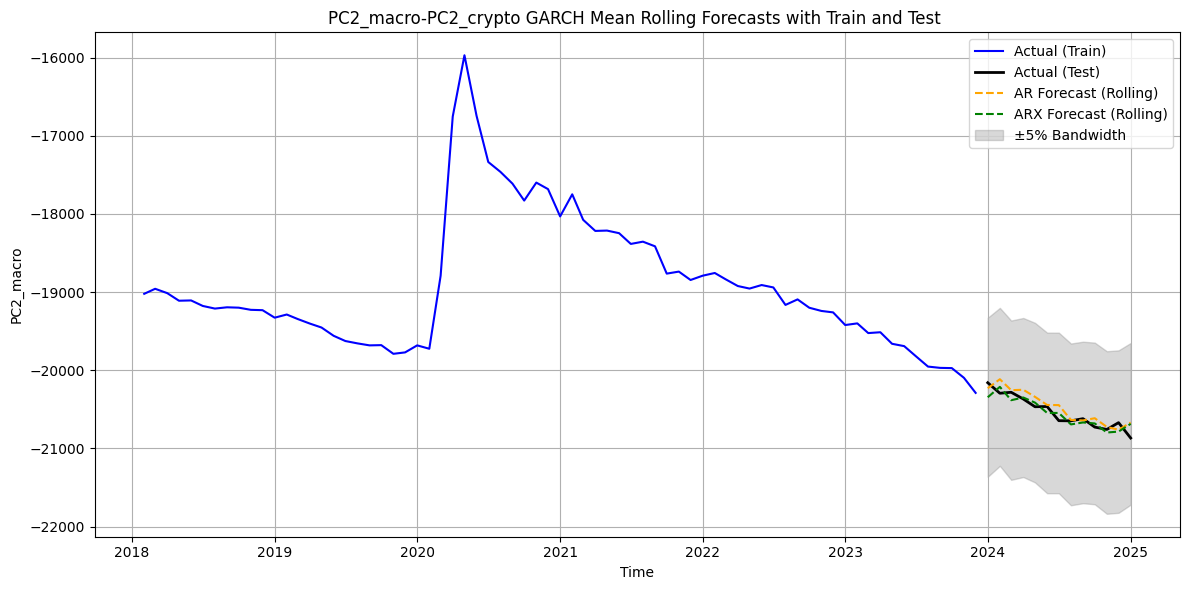

In [99]:
plot_garch_with_train_test(df, 'PC2_macro', 'PC2_crypto', 'PC2_macro', 1, 1, 1)


📊 PC1_macro-Tether
MAPE AR: 0.40%, ARX: 0.62%, Improvement: 55.81%
R² AR: 0.7188, R² ARX: 0.4221


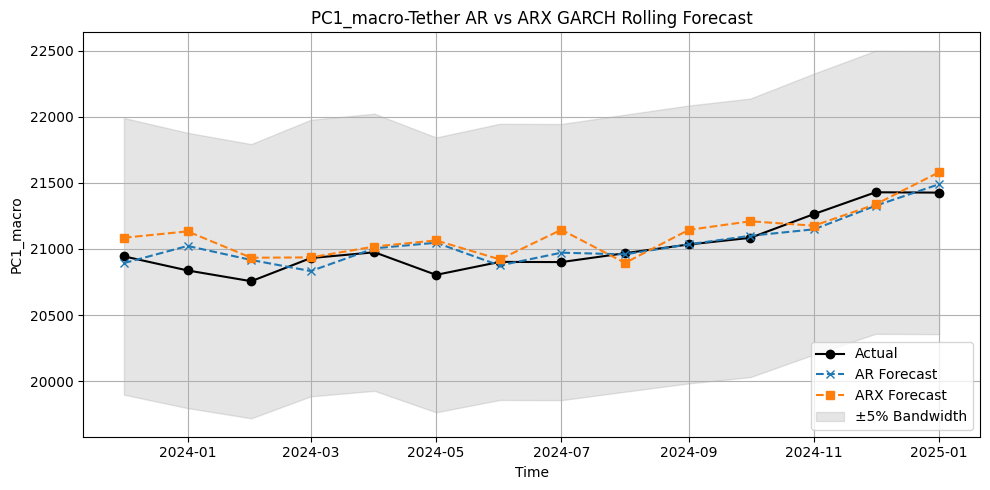


📊 PC1_macro-USD Coin
MAPE AR: 0.55%, ARX: 0.43%, Improvement: -20.99%
R² AR: 0.5418, R² ARX: 0.6667


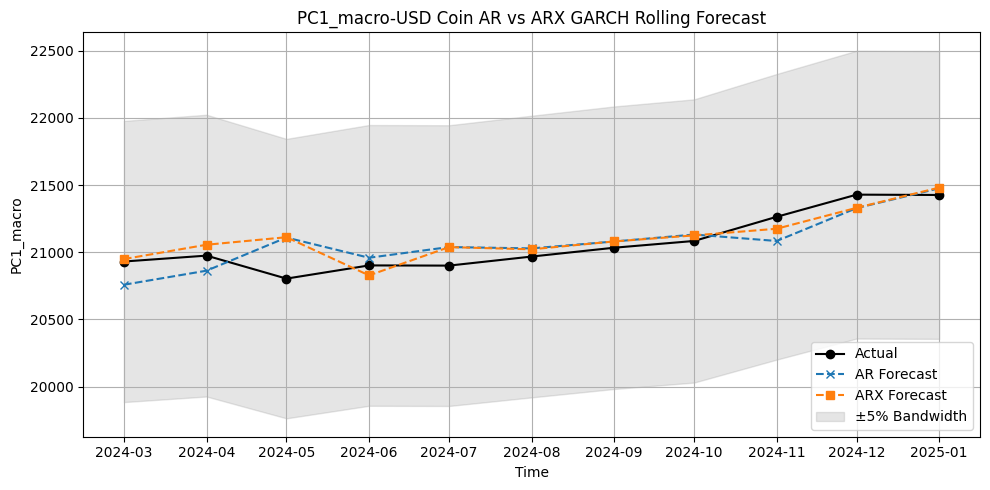


📊 PC1_macro-PC1_crypto
MAPE AR: 0.42%, ARX: 1.17%, Improvement: 181.62%
R² AR: 0.7147, R² ARX: -0.9794


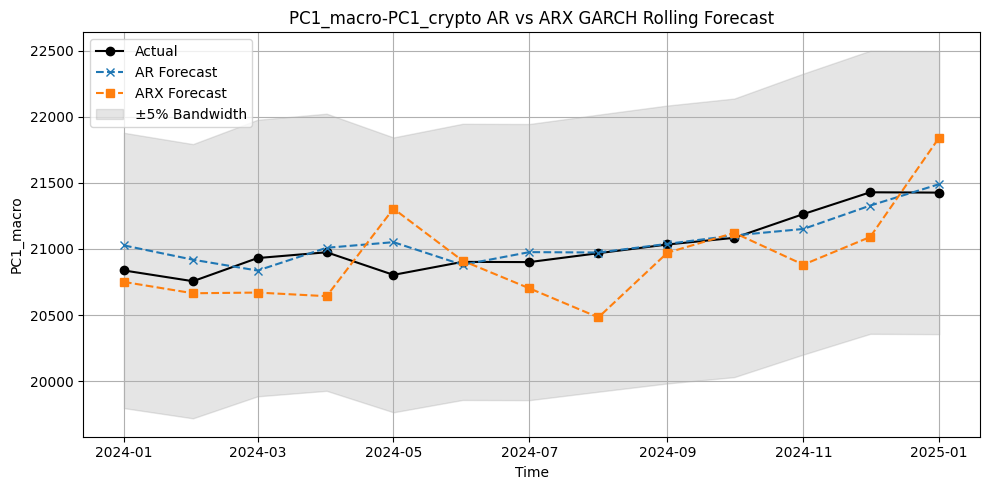


📊 PC1_macro-PC2_crypto
MAPE AR: 0.42%, ARX: 0.73%, Improvement: 74.80%
R² AR: 0.7147, R² ARX: 0.2762


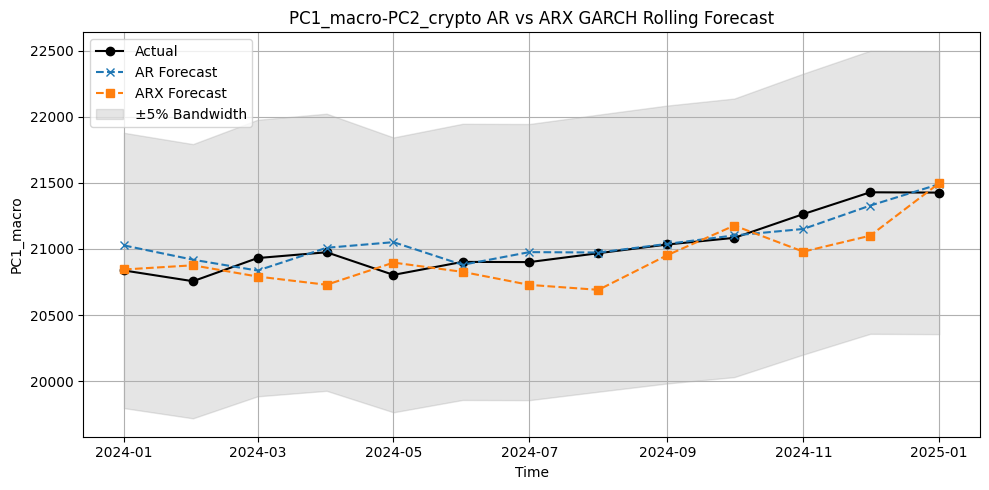


📊 PC2_macro-Tether
MAPE AR: 0.44%, ARX: 0.45%, Improvement: 2.69%
R² AR: 0.7376, R² ARX: 0.7490


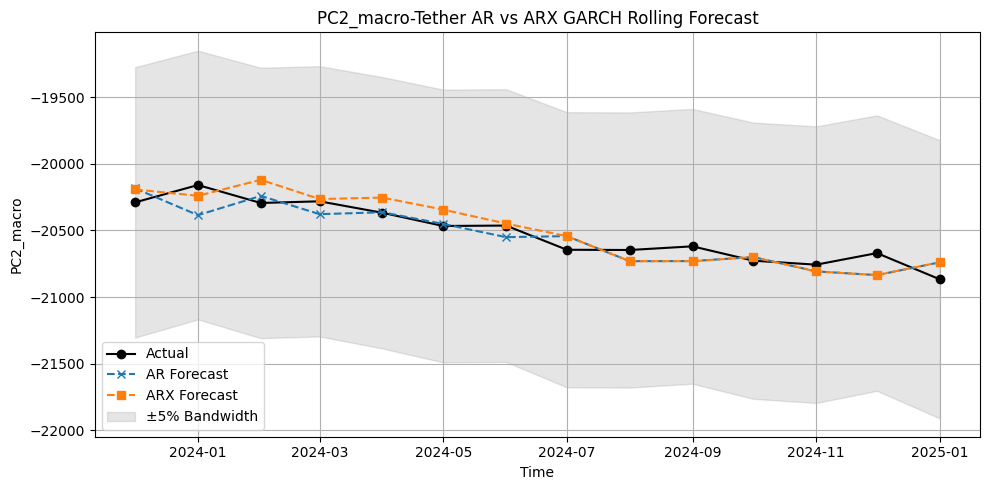


📊 PC2_macro-USD Coin
MAPE AR: 0.39%, ARX: 0.39%, Improvement: -0.44%
R² AR: 0.6200, R² ARX: 0.6223


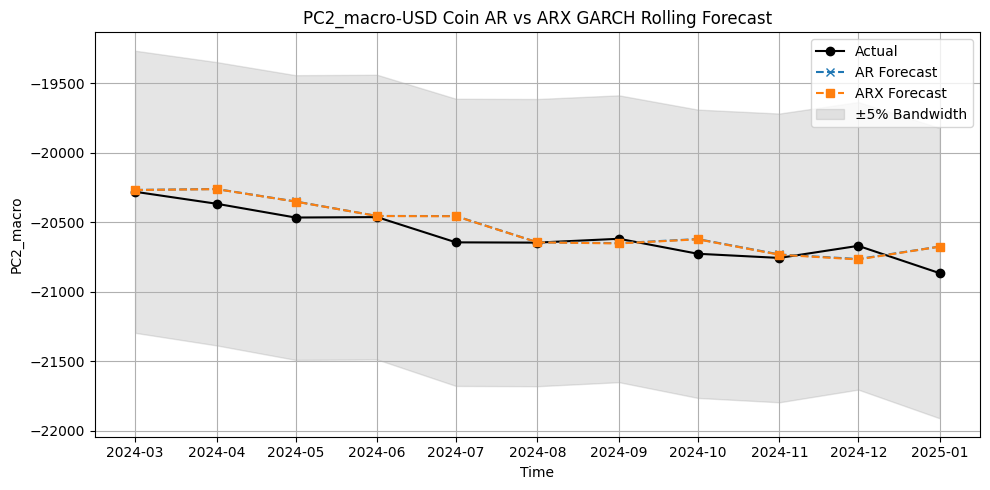


📊 PC2_macro-PC1_crypto
MAPE AR: 0.51%, ARX: 0.54%, Improvement: 6.19%
R² AR: 0.6494, R² ARX: 0.5753


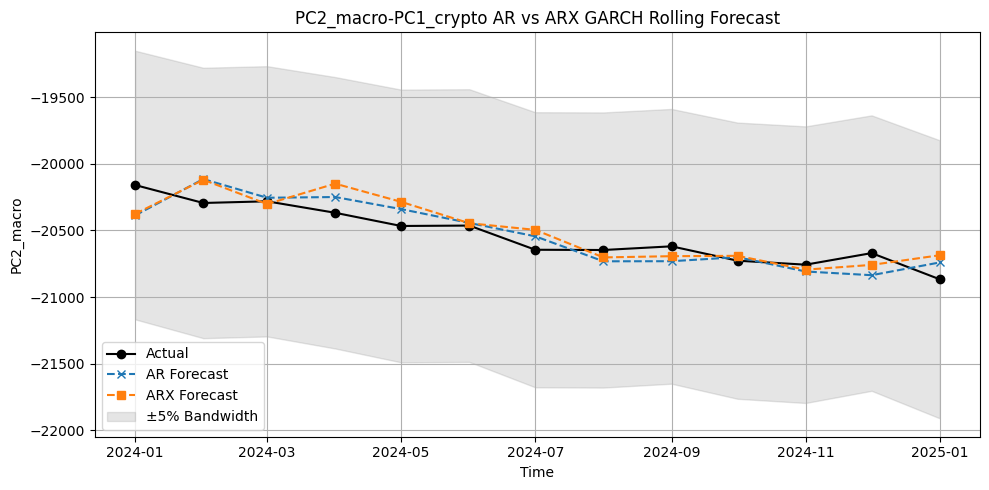


📊 PC2_macro-PC2_crypto
MAPE AR: 0.45%, ARX: 0.41%, Improvement: -9.01%
R² AR: 0.6897, R² ARX: 0.7711


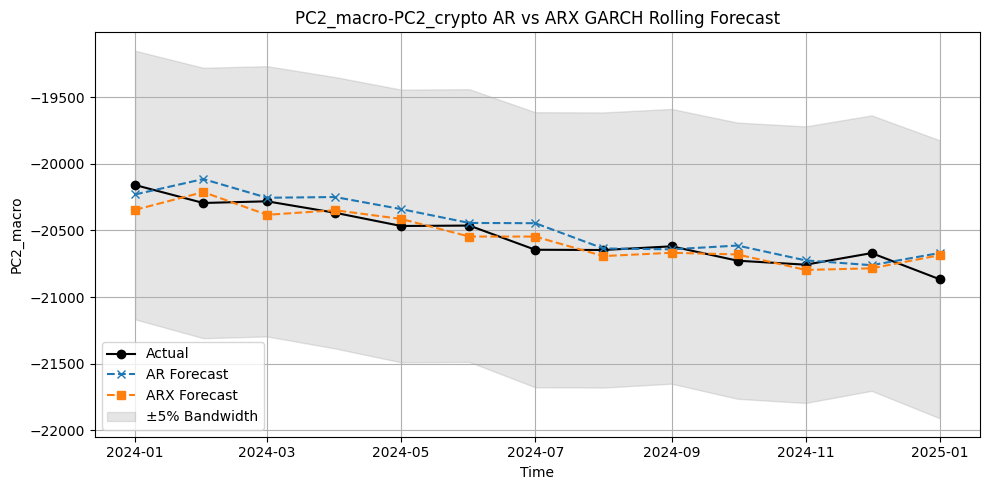

,Macro,Crypto,p,q,Exog Lag,MAPE_AR,MAPE_ARX,R2_AR,R2_ARX,MAPE_Improvement(%)
1,PC1_macro,USD Coin,1,1,4,0.549726,0.434324,0.541813,0.666686,-20.992646
7,PC2_macro,PC2_crypto,1,1,0,0.452298,0.411554,0.689737,0.771123,-9.008191
5,PC2_macro,USD Coin,1,1,2,0.388412,0.386716,0.620018,0.622330,-0.436609
4,PC2_macro,Tether,2,1,0,0.436748,0.448515,0.737592,0.749032,2.694306
6,PC2_macro,PC1_crypto,2,1,0,0.512783,0.544527,0.649355,0.575302,6.190591
0,PC1_macro,Tether,1,1,0,0.400168,0.623482,0.718766,0.422077,55.805051
3,PC1_macro,PC2_crypto,1,1,1,0.415378,0.726074,0.714694,0.276167,74.798268
2,PC1_macro,PC1_crypto,1,1,1,0.415378,1.169790,0.714694,-0.979427,181.620435


In [100]:
# Format: ('macro_name', 'crypto_name'): {'p': x, 'q': y, 'lag': z}
pair_orders = {
    ('PC1_macro', 'Tether'): {'p': 1, 'q': 1, 'lag': 0},
    ('PC1_macro', 'USD Coin'): {'p': 1, 'q': 1, 'lag': 4},
    ('PC1_macro', 'PC1_crypto'): {'p': 1, 'q': 1, 'lag': 1},
    ('PC1_macro', 'PC2_crypto'): {'p': 1, 'q':1, 'lag': 1},

    ('PC2_macro', 'Tether'): {'p': 2, 'q': 1, 'lag': 0},
    ('PC2_macro', 'USD Coin'): {'p': 1, 'q': 1, 'lag': 2},
    ('PC2_macro', 'PC1_crypto'): {'p': 2, 'q': 1, 'lag': 0},
    ('PC2_macro', 'PC2_crypto'): {'p': 1, 'q': 1, 'lag': 0},

}

from arch import arch_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def safe_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100 if np.any(mask) else np.nan

def rolling_forecast_ar(y_train_scaled, y_test_scaled, p, q, l):
    history = list(y_train_scaled)
    preds = []
    for t in range(len(y_test_scaled)):
        model = arch_model(history, mean='AR', lags=l, vol='GARCH', p=p, q=q, dist='normal', rescale=False)
        res = model.fit(disp='off')
        forecast = res.forecast(horizon=1, method='analytic')
        pred = forecast.mean.values[-1, 0]
        preds.append(pred)
        history.append(y_test_scaled[t])
    return np.array(preds)

def rolling_forecast_arx(y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, p, q, l):
    history_y = list(y_train_scaled)
    history_x = list(x_train_scaled)
    preds = []
    for t in range(len(y_test_scaled)):
        x_arr = np.array(history_x)
        model = arch_model(history_y, mean='ARX', lags=l, vol='GARCH', p=p, q=q, x=x_arr, dist='normal', rescale=False)
        res = model.fit(disp='off')
        const = res.params.get('Const', 0)
        phi = res.params.get('y[1]', 0)
        beta = res.params.get('x0', 0)
        y_t = history_y[-1]
        x_t1 = x_test_scaled[t]
        pred = const + phi * y_t + beta * x_t1
        preds.append(pred)
        history_y.append(y_test_scaled[t])
        history_x.append(x_test_scaled[t])
    return np.array(preds)

results = []

for (macro, asset), params in pair_orders.items():
    if f'{macro}_diff_diff' in df.columns:
        y_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in df.columns:
        y_col = f'{macro}_diff'
    else:
        y_col = macro

    if macro not in df.columns or asset not in df.columns:
        print(f"Skipping {macro}-{asset}: missing in DataFrame")
        continue

    p, q, lag = params['p'], params['q'], params['lag']
    df_temp = df[[y_col, asset]].copy()
    df_temp[asset] = df_temp[asset].shift(lag)
    df_temp.dropna(inplace=True)

    if len(df_temp) < 30:
        print(f"Skipping {macro}-{asset}: insufficient data")
        continue

    y_var, x_var = df_temp[y_col].var(), df_temp[asset].var()
    if y_var == 0 or x_var == 0:
        print(f"Skipping {macro}-{asset}: zero variance")
        continue

    # Train-test split
    train_size = int(len(df_temp) * 0.85)
    df_train, df_test = df_temp.iloc[:train_size], df_temp.iloc[train_size:]

    # Scale
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(df_train[[y_col]]).flatten()
    x_train_scaled = scaler_x.fit_transform(df_train[[asset]]).flatten()
    y_test_scaled = scaler_y.transform(df_test[[y_col]]).flatten()
    x_test_scaled = scaler_x.transform(df_test[[asset]]).flatten()

    try:
        pred_ar_scaled = rolling_forecast_ar(y_train_scaled, y_test_scaled, p, q, 1)
        pred_arx_scaled = rolling_forecast_arx(y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, p, q, 1)

        pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()
        pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()
        y_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
        index_test = df_test.index

        mse_ar = mean_squared_error(y_actual, pred_ar)
        mse_arx = mean_squared_error(y_actual, pred_arx)
        r2_ar = r2_score(y_actual, pred_ar)
        r2_arx = r2_score(y_actual, pred_arx)
        mape_ar = safe_mape(y_actual, pred_ar)
        mape_arx = safe_mape(y_actual, pred_arx)
        mape_change = ((mape_arx - mape_ar) / mape_ar) * 100 if mape_ar != 0 else np.nan

        print(f"\n📊 {macro}-{asset}")
        print(f"MAPE AR: {mape_ar:.2f}%, ARX: {mape_arx:.2f}%, Improvement: {mape_change:.2f}%")
        print(f"R² AR: {r2_ar:.4f}, R² ARX: {r2_arx:.4f}")

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(index_test, y_actual, label='Actual', color='black', marker='o')
        plt.plot(index_test, pred_ar, label='AR Forecast', linestyle='--', marker='x')
        plt.plot(index_test, pred_arx, label='ARX Forecast', linestyle='--', marker='s')
        plt.fill_between(index_test, y_actual * 0.95, y_actual * 1.05, color='gray', alpha=0.2, label='±5% Bandwidth')
        plt.title(f'{macro}-{asset} AR vs ARX GARCH Rolling Forecast')
        plt.xlabel('Time')
        plt.ylabel(y_col)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        results.append({
            'Macro': macro,
            'Crypto': asset,
            'p': p,
            'q': q,
            'Exog Lag': lag,
            'MAPE_AR': mape_ar,
            'MAPE_ARX': mape_arx,
            'R2_AR': r2_ar,
            'R2_ARX': r2_arx,
            'MAPE_Improvement(%)': mape_change,
        })

    except Exception as e:
        print(f"⚠️ Forecast failed for {macro}-{asset}: {e}")

results_df = pd.DataFrame(results)
display(results_df.sort_values('MAPE_Improvement(%)'))



📊 PC1_macro-Tether
MAPE AR: 0.40%, ARX: 0.62%, Improvement: 55.81%
R² AR: 0.7188, R² ARX: 0.4221


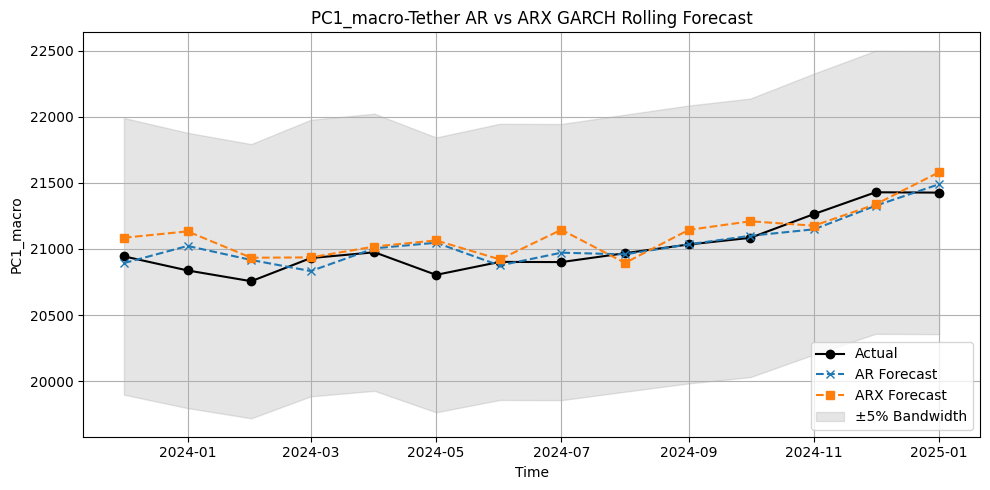


📊 PC1_macro-USD Coin
MAPE AR: 0.55%, ARX: 0.43%, Improvement: -20.99%
R² AR: 0.5418, R² ARX: 0.6667


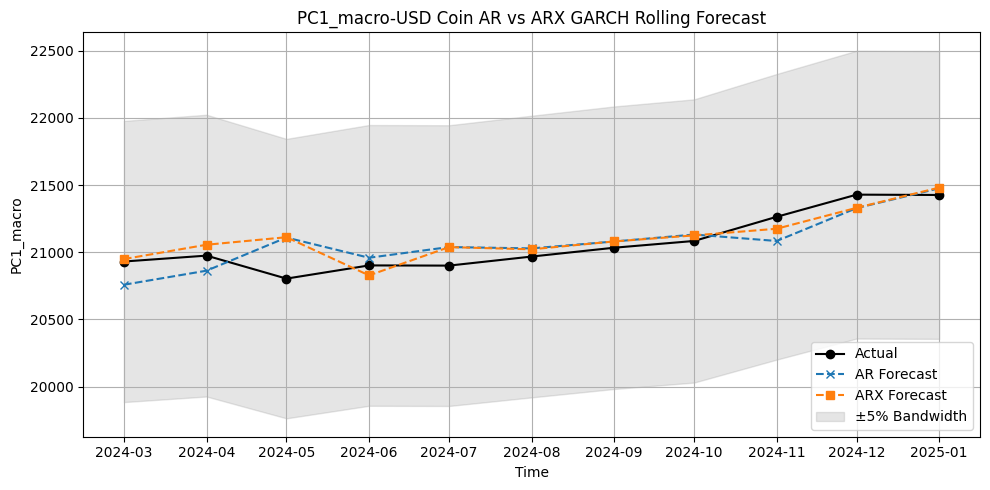


📊 PC1_macro-PC1_crypto
MAPE AR: 0.42%, ARX: 1.17%, Improvement: 181.62%
R² AR: 0.7147, R² ARX: -0.9794


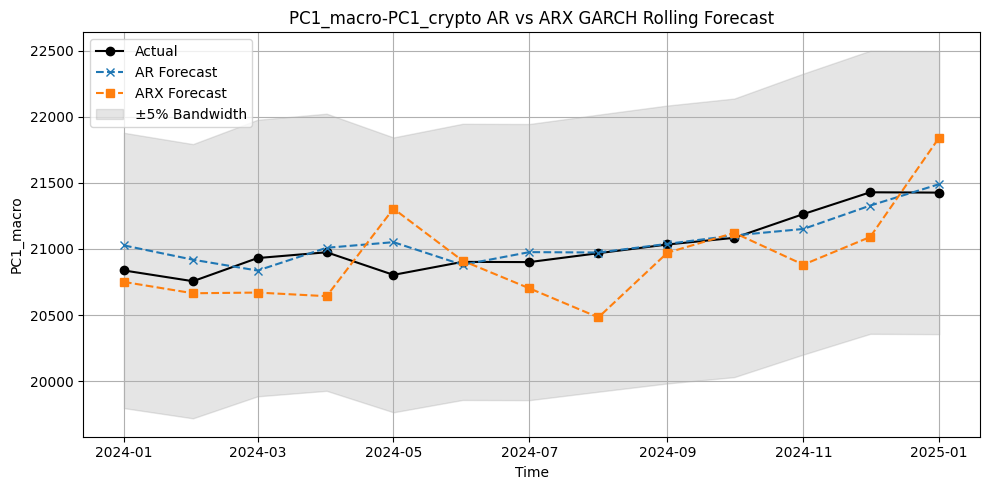


📊 PC1_macro-PC2_crypto
MAPE AR: 0.42%, ARX: 0.73%, Improvement: 74.80%
R² AR: 0.7147, R² ARX: 0.2762


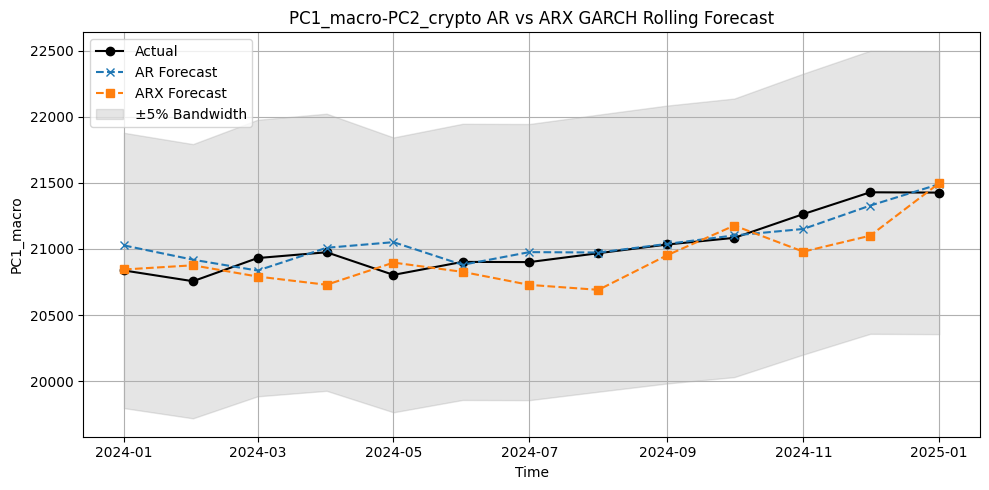


📊 PC2_macro-Tether
MAPE AR: 0.52%, ARX: 0.49%, Improvement: -4.90%
R² AR: 0.5996, R² ARX: 0.6466


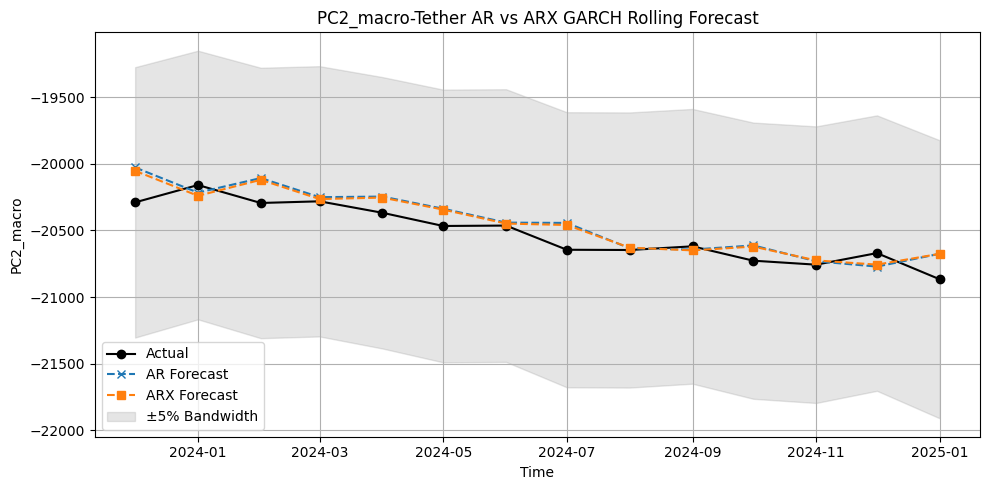


📊 PC2_macro-USD Coin
MAPE AR: 0.39%, ARX: 0.39%, Improvement: -0.44%
R² AR: 0.6200, R² ARX: 0.6223


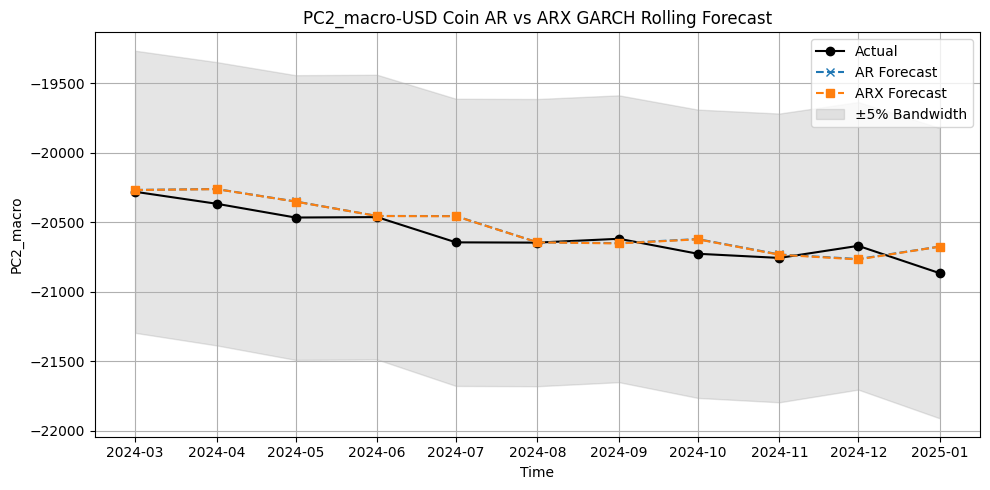


📊 PC2_macro-PC1_crypto
MAPE AR: 0.45%, ARX: 0.48%, Improvement: 6.55%
R² AR: 0.6897, R² ARX: 0.6121


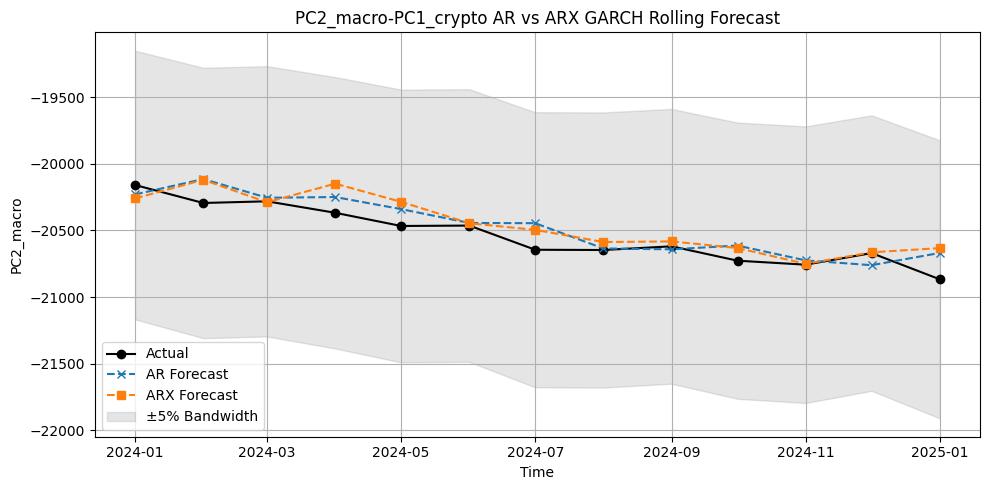


📊 PC2_macro-PC2_crypto
MAPE AR: 0.45%, ARX: 0.41%, Improvement: -9.01%
R² AR: 0.6897, R² ARX: 0.7711


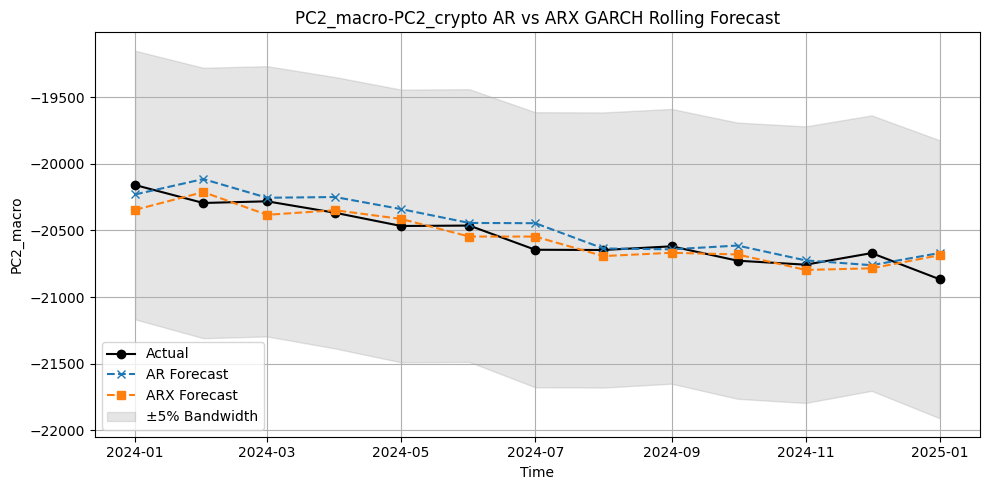

,Macro,Crypto,p,q,Exog Lag,MAPE_AR,MAPE_ARX,R2_AR,R2_ARX,MAPE_Improvement(%)
1,PC1_macro,USD Coin,1,1,4,0.549726,0.434324,0.541813,0.666686,-20.992646
7,PC2_macro,PC2_crypto,1,1,0,0.452298,0.411554,0.689737,0.771123,-9.008191
4,PC2_macro,Tether,1,1,0,0.516167,0.490871,0.599575,0.646650,-4.900799
5,PC2_macro,USD Coin,1,1,2,0.388412,0.386716,0.620018,0.622330,-0.436609
6,PC2_macro,PC1_crypto,1,1,0,0.452298,0.481946,0.689737,0.612077,6.554965
0,PC1_macro,Tether,1,1,0,0.400168,0.623482,0.718766,0.422077,55.805051
3,PC1_macro,PC2_crypto,1,1,1,0.415378,0.726074,0.714694,0.276167,74.798268
2,PC1_macro,PC1_crypto,1,1,1,0.415378,1.169790,0.714694,-0.979427,181.620435


In [101]:
# Format: ('macro_name', 'crypto_name'): {'p': x, 'q': y, 'lag': z}
pair_orders = {
    ('PC1_macro', 'Tether'): {'p': 1, 'q': 1, 'lag': 0},
    ('PC1_macro', 'USD Coin'): {'p': 1, 'q': 1, 'lag': 4},
    ('PC1_macro', 'PC1_crypto'): {'p': 1, 'q': 1, 'lag': 1},
    ('PC1_macro', 'PC2_crypto'): {'p': 1, 'q':1, 'lag': 1},

    ('PC2_macro', 'Tether'): {'p': 1, 'q': 1, 'lag': 0},
    ('PC2_macro', 'USD Coin'): {'p': 1, 'q': 1, 'lag': 2},
    ('PC2_macro', 'PC1_crypto'): {'p': 1, 'q': 1, 'lag': 0},
    ('PC2_macro', 'PC2_crypto'): {'p': 1, 'q': 1, 'lag': 0},

}

from arch import arch_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def safe_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100 if np.any(mask) else np.nan

def rolling_forecast_ar(y_train_scaled, y_test_scaled, p, q, l):
    history = list(y_train_scaled)
    preds = []
    for t in range(len(y_test_scaled)):
        model = arch_model(history, mean='AR', lags=l, vol='GARCH', p=p, q=q, dist='normal', rescale=False)
        res = model.fit(disp='off')
        forecast = res.forecast(horizon=1, method='analytic')
        pred = forecast.mean.values[-1, 0]
        preds.append(pred)
        history.append(y_test_scaled[t])
    return np.array(preds)

def rolling_forecast_arx(y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, p, q, l):
    history_y = list(y_train_scaled)
    history_x = list(x_train_scaled)
    preds = []
    for t in range(len(y_test_scaled)):
        x_arr = np.array(history_x)
        model = arch_model(history_y, mean='ARX', lags=l, vol='GARCH', p=p, q=q, x=x_arr, dist='normal', rescale=False)
        res = model.fit(disp='off')
        const = res.params.get('Const', 0)
        phi = res.params.get('y[1]', 0)
        beta = res.params.get('x0', 0)
        y_t = history_y[-1]
        x_t1 = x_test_scaled[t]
        pred = const + phi * y_t + beta * x_t1
        preds.append(pred)
        history_y.append(y_test_scaled[t])
        history_x.append(x_test_scaled[t])
    return np.array(preds)

results = []

for (macro, asset), params in pair_orders.items():
    if f'{macro}_diff_diff' in df.columns:
        y_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in df.columns:
        y_col = f'{macro}_diff'
    else:
        y_col = macro

    if macro not in df.columns or asset not in df.columns:
        print(f"Skipping {macro}-{asset}: missing in DataFrame")
        continue

    p, q, lag = params['p'], params['q'], params['lag']
    df_temp = df[[y_col, asset]].copy()
    df_temp[asset] = df_temp[asset].shift(lag)
    df_temp.dropna(inplace=True)

    if len(df_temp) < 30:
        print(f"Skipping {macro}-{asset}: insufficient data")
        continue

    y_var, x_var = df_temp[y_col].var(), df_temp[asset].var()
    if y_var == 0 or x_var == 0:
        print(f"Skipping {macro}-{asset}: zero variance")
        continue

    # Train-test split
    train_size = int(len(df_temp) * 0.85)
    df_train, df_test = df_temp.iloc[:train_size], df_temp.iloc[train_size:]

    # Scale
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(df_train[[y_col]]).flatten()
    x_train_scaled = scaler_x.fit_transform(df_train[[asset]]).flatten()
    y_test_scaled = scaler_y.transform(df_test[[y_col]]).flatten()
    x_test_scaled = scaler_x.transform(df_test[[asset]]).flatten()

    try:
        pred_ar_scaled = rolling_forecast_ar(y_train_scaled, y_test_scaled, p, q, 1)
        pred_arx_scaled = rolling_forecast_arx(y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, p, q, 1)

        pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()
        pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()
        y_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
        index_test = df_test.index

        mse_ar = mean_squared_error(y_actual, pred_ar)
        mse_arx = mean_squared_error(y_actual, pred_arx)
        r2_ar = r2_score(y_actual, pred_ar)
        r2_arx = r2_score(y_actual, pred_arx)
        mape_ar = safe_mape(y_actual, pred_ar)
        mape_arx = safe_mape(y_actual, pred_arx)
        mape_change = ((mape_arx - mape_ar) / mape_ar) * 100 if mape_ar != 0 else np.nan

        print(f"\n📊 {macro}-{asset}")
        print(f"MAPE AR: {mape_ar:.2f}%, ARX: {mape_arx:.2f}%, Improvement: {mape_change:.2f}%")
        print(f"R² AR: {r2_ar:.4f}, R² ARX: {r2_arx:.4f}")

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(index_test, y_actual, label='Actual', color='black', marker='o')
        plt.plot(index_test, pred_ar, label='AR Forecast', linestyle='--', marker='x')
        plt.plot(index_test, pred_arx, label='ARX Forecast', linestyle='--', marker='s')
        plt.fill_between(index_test, y_actual * 0.95, y_actual * 1.05, color='gray', alpha=0.2, label='±5% Bandwidth')
        plt.title(f'{macro}-{asset} AR vs ARX GARCH Rolling Forecast')
        plt.xlabel('Time')
        plt.ylabel(y_col)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        results.append({
            'Macro': macro,
            'Crypto': asset,
            'p': p,
            'q': q,
            'Exog Lag': lag,
            'MAPE_AR': mape_ar,
            'MAPE_ARX': mape_arx,
            'R2_AR': r2_ar,
            'R2_ARX': r2_arx,
            'MAPE_Improvement(%)': mape_change,
        })

    except Exception as e:
        print(f"⚠️ Forecast failed for {macro}-{asset}: {e}")

results_df = pd.DataFrame(results)
display(results_df.sort_values('MAPE_Improvement(%)'))


## Optimizing Crypto Lag


✅ Best lag for PC1_macro-Tether is 4 with MAPE improvement 0.42%


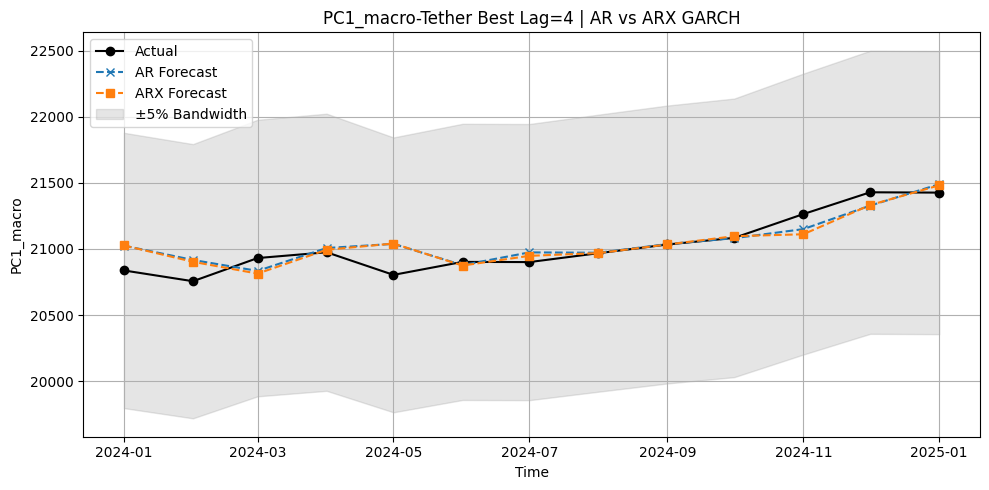

/Users/tianyishen/Desktop/CSUREMM project/CryptoMacroecon-Prediction-CSUREMM-1/.venv/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



✅ Best lag for PC1_macro-USD Coin is 4 with MAPE improvement -20.99%


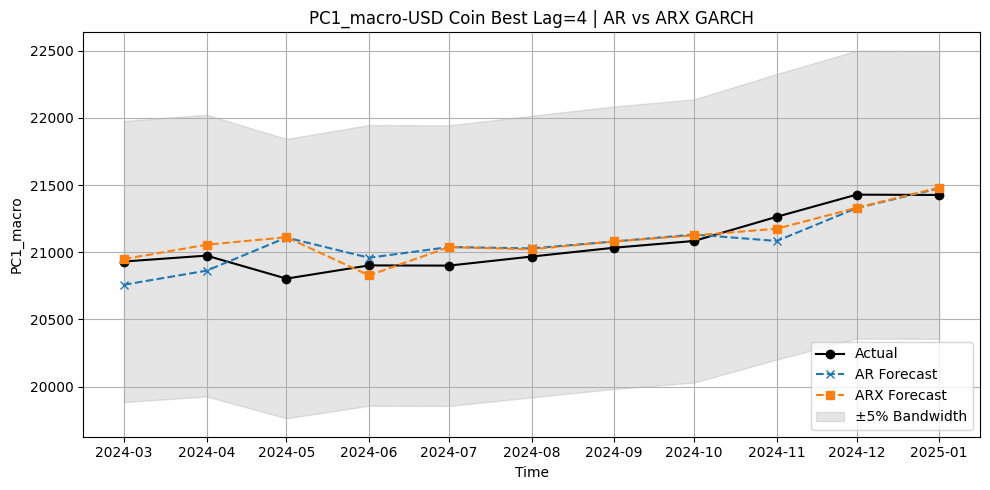


✅ Best lag for PC1_macro-PC1_crypto is 2 with MAPE improvement -4.92%


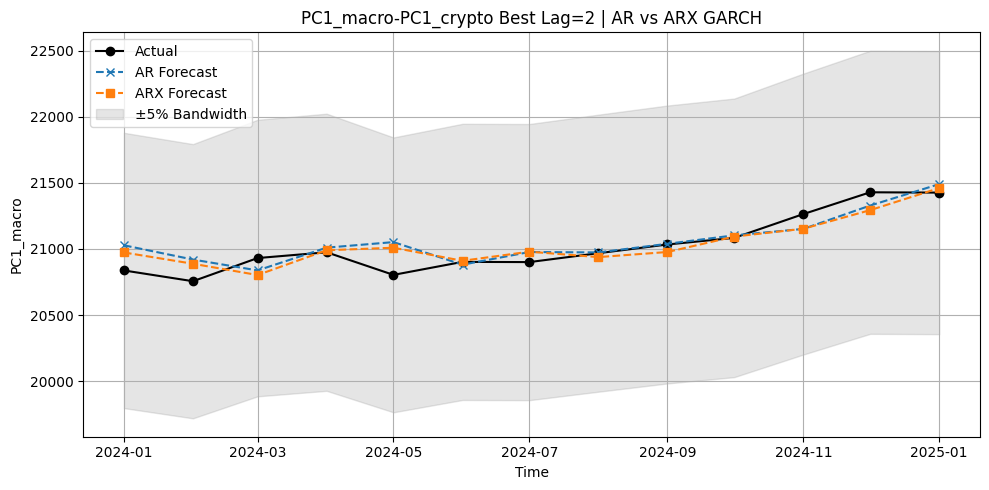


✅ Best lag for PC1_macro-PC2_crypto is 2 with MAPE improvement -2.32%


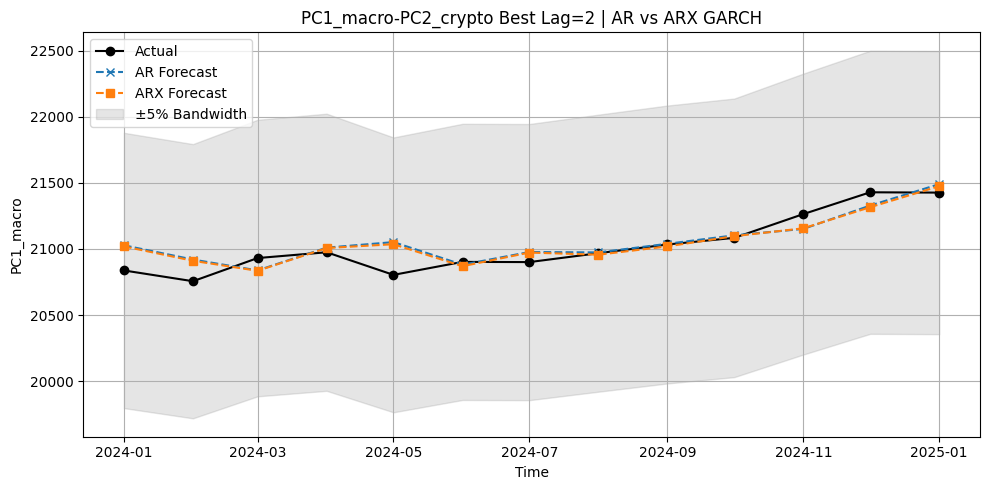


✅ Best lag for PC2_macro-Tether is 3 with MAPE improvement -5.30%


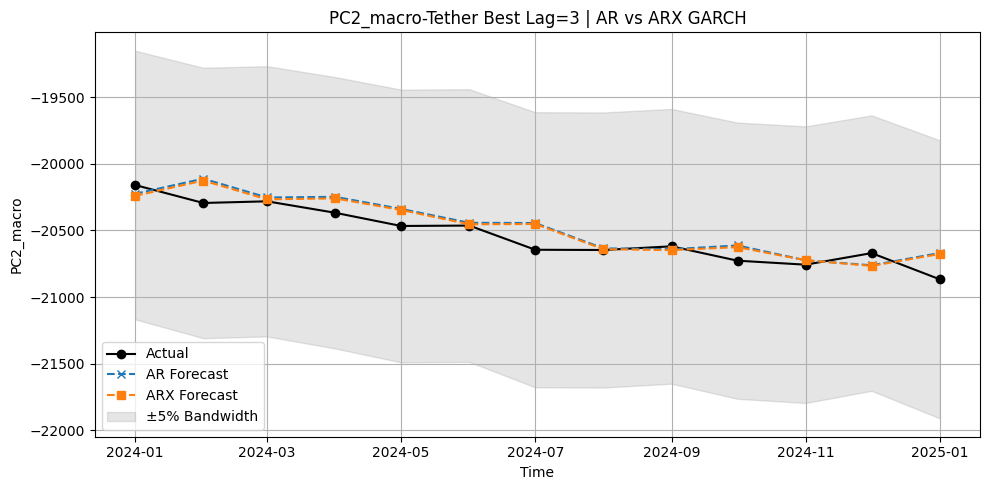


✅ Best lag for PC2_macro-USD Coin is 0 with MAPE improvement -4.63%


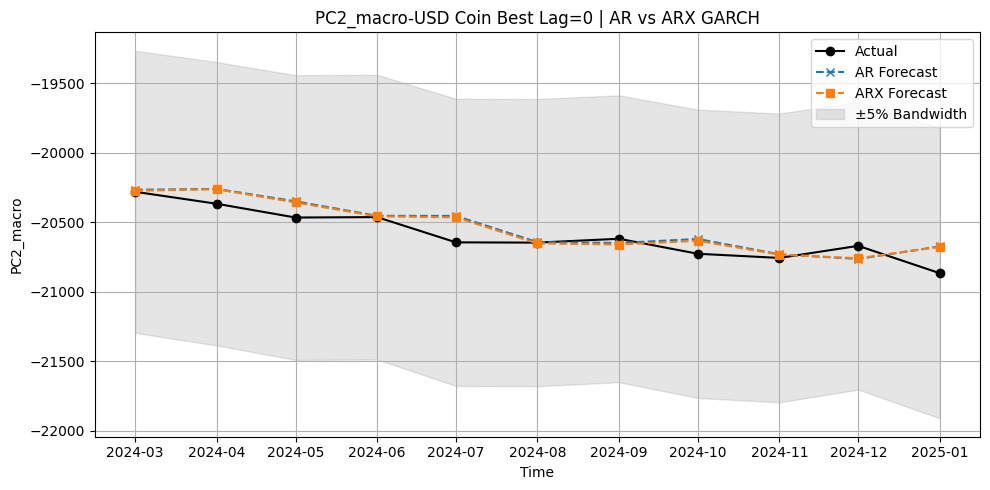


✅ Best lag for PC2_macro-PC1_crypto is 4 with MAPE improvement 0.88%


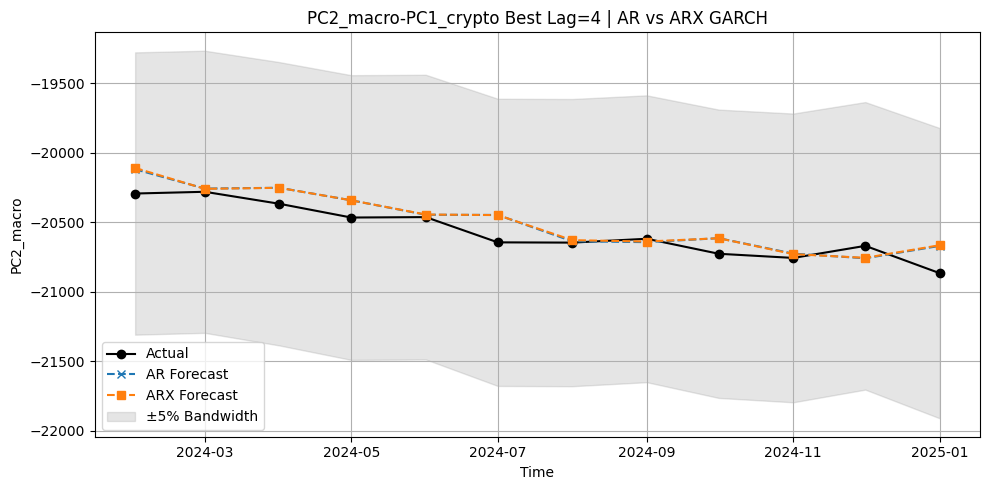


✅ Best lag for PC2_macro-PC2_crypto is 6 with MAPE improvement -16.96%


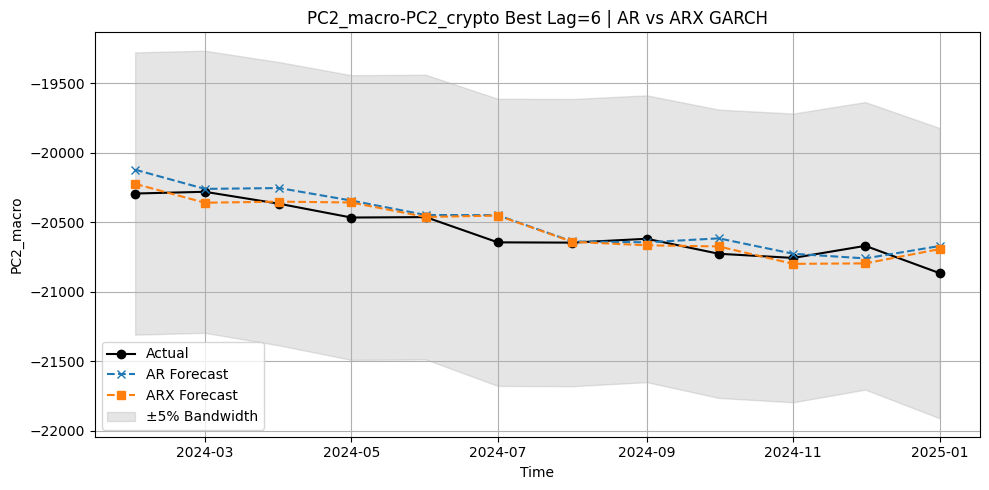

,Macro,Crypto,p,q,Exog Lag,MAPE_AR,MAPE_ARX,R2_AR,R2_ARX,MAPE_Improvement(%)
1,PC1_macro,USD Coin,1,1,4,0.549726,0.434324,0.541813,0.666686,-20.992646
7,PC2_macro,PC2_crypto,1,1,6,0.444533,0.369126,0.603747,0.713325,-16.963216
4,PC2_macro,Tether,1,1,3,0.454966,0.430846,0.686229,0.714214,-5.301471
2,PC1_macro,PC1_crypto,1,1,2,0.416624,0.396130,0.713448,0.766146,-4.918881
5,PC2_macro,USD Coin,1,1,0,0.391123,0.373002,0.616500,0.649497,-4.633048
3,PC1_macro,PC2_crypto,1,1,2,0.416624,0.406949,0.713448,0.736523,-2.322199
0,PC1_macro,Tether,1,1,4,0.402793,0.404475,0.727663,0.715837,0.417650
6,PC2_macro,PC1_crypto,1,1,4,0.450314,0.454296,0.595974,0.585633,0.884342


In [103]:
results = []

for (macro, asset), base_params in pair_orders.items():
    if f'{macro}_diff_diff' in df.columns:
        y_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in df.columns:
        y_col = f'{macro}_diff'
    else:
        y_col = macro

    if macro not in df.columns or asset not in df.columns:
        print(f"Skipping {macro}-{asset}: missing in DataFrame")
        continue

    p, q = base_params['p'], base_params['q']
    best_result = None

    for lag in range(0, 7):
        df_temp = df[[y_col, asset]].copy()
        df_temp[asset] = df_temp[asset].shift(lag)
        df_temp.dropna(inplace=True)

        if len(df_temp) < 30:
            continue

        if df_temp[y_col].var() == 0 or df_temp[asset].var() == 0:
            continue

        # Train-test split
        train_size = int(len(df_temp) * 0.85)
        df_train, df_test = df_temp.iloc[:train_size], df_temp.iloc[train_size:]

        scaler_y = StandardScaler()
        scaler_x = StandardScaler()
        y_train_scaled = scaler_y.fit_transform(df_train[[y_col]]).flatten()
        x_train_scaled = scaler_x.fit_transform(df_train[[asset]]).flatten()
        y_test_scaled = scaler_y.transform(df_test[[y_col]]).flatten()
        x_test_scaled = scaler_x.transform(df_test[[asset]]).flatten()

        try:
            pred_ar_scaled = rolling_forecast_ar(y_train_scaled, y_test_scaled, p, q, 1)
            pred_arx_scaled = rolling_forecast_arx(y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, p, q, 1)

            pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()
            pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()
            y_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
            index_test = df_test.index

            mse_ar = mean_squared_error(y_actual, pred_ar)
            mse_arx = mean_squared_error(y_actual, pred_arx)
            r2_ar = r2_score(y_actual, pred_ar)
            r2_arx = r2_score(y_actual, pred_arx)
            mape_ar = safe_mape(y_actual, pred_ar)
            mape_arx = safe_mape(y_actual, pred_arx)
            mape_change = ((mape_arx - mape_ar) / mape_ar) * 100 if mape_ar != 0 else np.nan

            if best_result is None or (mape_change < best_result['MAPE_Improvement(%)']):
                best_result = {
                    'Macro': macro,
                    'Crypto': asset,
                    'p': p,
                    'q': q,
                    'Exog Lag': lag,
                    'MAPE_AR': mape_ar,
                    'MAPE_ARX': mape_arx,
                    'R2_AR': r2_ar,
                    'R2_ARX': r2_arx,
                    'MAPE_Improvement(%)': mape_change,
                    'index_test': index_test,
                    'y_actual': y_actual,
                    'pred_ar': pred_ar,
                    'pred_arx': pred_arx,
                    'y_col': y_col
                }

        except Exception as e:
            print(f"⚠️ Forecast failed for {macro}-{asset} lag={lag}: {e}")

    if best_result:
        results.append({k: v for k, v in best_result.items() if k not in ['index_test', 'y_actual', 'pred_ar', 'pred_arx', 'y_col']})

        print(f"\n✅ Best lag for {macro}-{asset} is {best_result['Exog Lag']} with MAPE improvement {best_result['MAPE_Improvement(%)']:.2f}%")

        # Plot best result
        plt.figure(figsize=(10, 5))
        plt.plot(best_result['index_test'], best_result['y_actual'], label='Actual', color='black', marker='o')
        plt.plot(best_result['index_test'], best_result['pred_ar'], label='AR Forecast', linestyle='--', marker='x')
        plt.plot(best_result['index_test'], best_result['pred_arx'], label='ARX Forecast', linestyle='--', marker='s')
        plt.fill_between(best_result['index_test'], best_result['y_actual'] * 0.95, best_result['y_actual'] * 1.05, color='gray', alpha=0.2, label='±5% Bandwidth')
        plt.title(f"{macro}-{asset} Best Lag={best_result['Exog Lag']} | AR vs ARX GARCH")
        plt.xlabel("Time")
        plt.ylabel(best_result['y_col'])
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

results_df = pd.DataFrame(results)
display(results_df.sort_values('MAPE_Improvement(%)'))
